# Pydantic

Pydantic is a powerful Python library used primarily for data validation and settings management using Python type hints.

In [16]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class State(BaseModel):
    a:str

def node(state:State):
    return {"a":"Hello welcome to Agentic AI"}


In [17]:
# Build the state graph

builder=StateGraph(State)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)
graph=builder.compile()

In [18]:
graph.invoke({"a":"Hello"})

{'a': 'Hello welcome to Agentic AI'}

## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [34]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return OverallState(a=231)

def ok_node(state:OverallState):
    return OverallState(a="Good bye")

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()





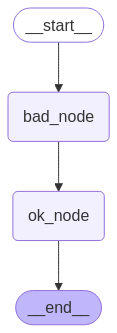

In [35]:
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
# Test the graph with a valid input
try:
   response= graph.invoke({"a": "Rahul"})
   print(response)
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

{'a': 'Good bye'}


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![image.png](attachment:image.png)

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

![image.png](attachment:image.png)

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

![image.png](attachment:image.png)

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

![image.png](attachment:image.png)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

![image.png](attachment:image.png)